# Example power spectrum calculation
In this example, we will calculate the matter power spectrum using a couple of different methods.

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt
import math
%matplotlib inline

We begin by defining a set of cosmological parameters, as usual:

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, 
                      transfer_function='boltzmann_class')

Note that we have explicitly defined how transfer functions should be calculated for the matter power spectrum, by using the `transfer_function` keyword argument. The following types of transfer function are available:

In [3]:
print(ccl.core.transfer_function_types.keys())

dict_keys(['none', 'emulator', 'fitting_function', 'eisenstein_hu', 'bbks', 'boltzmann', 'boltzmann_camb', 'camb', 'boltzmann_class', 'class'])


The default is `boltzmann_class`, which uses a full transfer function calculation from the CLASS Boltzmann code. This is one of the most accurate options at the level of linear pertubation theory, but will be less accurate at non-linear scales.

(To improve precision on non-linear scales, one would eventually choose `emulator`, which will use a suite of fast N-body simulations to model the matter transfer function. This is not currently implemented.)

If we were less interested in precision but wanted to improve speed, we could have chosen the `eisenstein_hu` option instead.

Likewise, the `Cosmology()` object constructor also has a `matter_power_spectrum` argument that can be changed. There is no need to do this for now, however.

### How CCL caches results
Now, we can calculate the linear and non-linear matter power spectra as a function of wavenumber. Before we do that though, let's just perform a quick test to see how CCL caches the results of calculations:

In [4]:
print(cosmo.has_power())
print(cosmo.has_sigma())

False
False


Both of these status indicators are `False`, showing that CCL hasn't yet computer power spectra (transfer functions) or sigma(R); the cache is currently empty. When we calculate the power spectrum, though, the result will be stored (and splined) for future use.

### Calculate the matter power spectrum
Now, let's calculate the power spectra:

In [5]:
kmin=1e-4
kmax=1e1
nk=128
k = np.logspace(np.log10(kmin), np.log10(kmax), nk) # Wavenumber
a = 1. # Scale factor

In [6]:
pk_lin = ccl.linear_matter_power(cosmo, k, a)

In [7]:
pk_nl = ccl.nonlin_matter_power(cosmo, k, a)

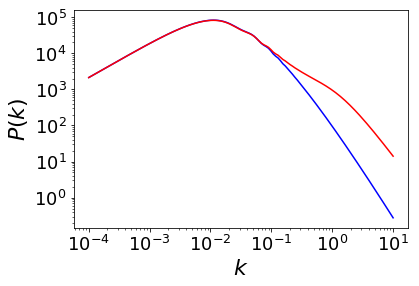

In [8]:
plt.plot(k, pk_lin, 'b-')
plt.plot(k, pk_nl, 'r-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$',fontsize=22)
plt.ylabel(r'$P(k)$',fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

We can see that the cache has now been populated:

In [9]:
print(cosmo.has_power())

True


Subsequent calls to `linear_matter_power()` will be faster for the same cosmology (i.e. the same `Cosmology` object).

### Power spectrum normalisation, sigma8
We can also calculate the normalisation of the power spectrum, sigma8. Note that this parameter is currently undefined:

In [10]:
print(cosmo['sigma8'])

nan


If we now call the `sigma8()` function, this value should be populated (although at present this has not been implemented).

In [11]:
print(ccl.sigma8(cosmo))
print(cosmo['sigma8'])

0.8404212646545005
nan


### Adding the impact of baryons
The power spectrum can also be modified to include the impact of baryons. The overall effect will be to include a scale-dependence which will suppress the power spectrum at scales smaller than a few Mpc/h. Here is an example:

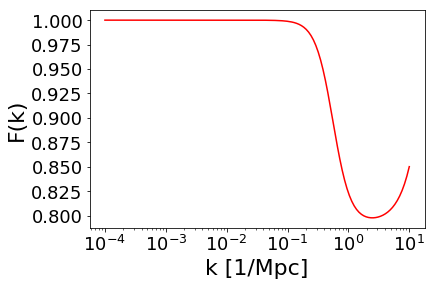

In [12]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)
cosmo_bar = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96,baryons_power_spectrum='bcm')
pk_nl = ccl.nonlin_matter_power(cosmo, k, a)
pk_nl_bar = ccl.nonlin_matter_power(cosmo_bar, k, a)
plt.plot(k, pk_nl_bar/pk_nl, 'r-')
plt.xscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('k [1/Mpc]',fontsize=22)
plt.ylabel('F(k)',fontsize=22)
plt.show()

### Using the cosmic emulator
The power spectrum can also be obtained from the cosmic emulator. In this case, the user needs to pass suitable choices for the transfer function and matter power spectrum. Here is an example:

In [13]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.05, h=0.67, sigma8=0.8, n_s=0.96,\
                      Neff=3.04, transfer_function='emulator',matter_power_spectrum='emu')

Then we proceed as usual for obtaining the matter power spectrum. Bear in mind that in the case of the linear matter power spectrum, even if you set the "emulator" flags, CLASS will be used.

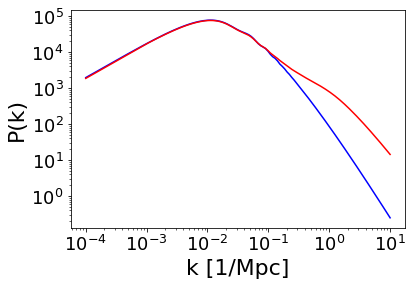

In [14]:
pk_nl = ccl.nonlin_matter_power(cosmo, k, a)
pk_lin = ccl.linear_matter_power(cosmo, k, a)
plt.plot(k, pk_lin, 'b-')
plt.plot(k, pk_nl, 'r-')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('k [1/Mpc]',fontsize=22)
plt.ylabel('P(k)',fontsize=22)
plt.show()

### Cosmologies with neutrinos
CCL supports equal and unequal neutrino mass cosmologies. We give some examples below of how to set them up and obtain power spectra for them. Note that for the emulator case, we only support equal-mass cases.

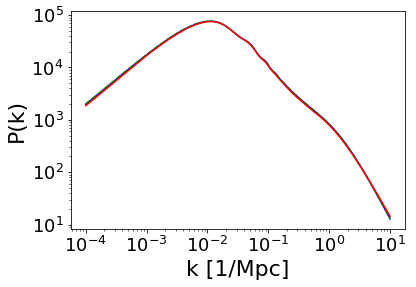

In [15]:
cosmo_nu_eq = ccl.Cosmology(Omega_c=0.27, Omega_b=0.05, h=0.67, sigma8=0.8, n_s=0.96,\
                      Neff=3, m_nu = 0.06,mnu_type='sum_equal')
pk_nl_nu_eq = ccl.nonlin_matter_power(cosmo_nu_eq, k, a)
cosmo_nu_uneq = ccl.Cosmology(Omega_c=0.27, Omega_b=0.05, h=0.67, sigma8=0.8, n_s=0.96,\
                      Neff=3, m_nu = [0.02,0.03,0.04],mnu_type='list')
pk_nl_nu_uneq = ccl.nonlin_matter_power(cosmo_nu_uneq, k, a)
plt.plot(k, pk_nl_nu_eq, 'b-')
plt.plot(k, pk_nl_nu_uneq, 'g--')
plt.plot(k, pk_nl, 'r-')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('k [1/Mpc]',fontsize=22)
plt.ylabel('P(k)',fontsize=22)
plt.show()